Discrete Sim of lost person dynamics

inputs:
- landscape: some array of coordinates, each cell with
    - elevation
    - amount of linear-feature-ness
- Person:
    - gets tired, store energy
    - profiles
        - random
        -


In [21]:
!pip install noise

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2 # just for realistic elevation generation
np.random.seed(0)

In [29]:
class Agent:
    def __init__(self, start_position, profile=[1,0,0,0,0,0,0]):
        self.position = np.array(start_position)
        self.energy = 100
        self.profile = profile
        self.history = []

    def random_walk(self, landscape):
        direction = np.random.randint(-1, 2, size=2)
        new_position = self.position + direction

        new_position = np.clip(new_position, 0, landscape.size - 1) # out of bounds stuff

        self.position = new_position
        self.energy -= 1  # TODO factor in elevation, maybe other stuff

        self.history.append(tuple(self.position))

    def route_travel(self, landscape):
        pass

    def direction_travel(self, landscape):
        pass

    def stay_put(self, landscape):
        pass

    def view_enhance(self, landscape):
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]

        current_x, current_y = self.position
        current_elevation = landscape.elevation[current_x, current_y]

        best_position = self.position
        best_elevation = current_elevation

        for dx, dy in directions:
            nx, ny = current_x + dx, current_y + dy
            if 0 <= nx < landscape.size and 0 <= ny < landscape.size:
                elevation = landscape.elevation[nx, ny]
                if elevation > best_elevation:
                    best_position, best_elevation = [nx, ny], elevation

        self.position = np.array(best_position)
        self.energy -= 1
        self.history.append(tuple(self.position))

    def backtrack(self, landscape):
        new_position = self.history[-1]
        self.position = new_position
        self.history.append(tuple(self.position))


    def reset(self):
        self.energy = 100
        self.history = []


class Landscape:
    def __init__(self, size):
        self.size = size
        self.elevation = self.generate_elevation()

    def generate_elevation(self):
        # Courtesy of gpt
        scale = 100.0        # Controls the zoom level of the noise
        octaves = 6          # Number of noise layers, higher octaves add more detail
        persistence = 0.5    # Influence of each octave on the final result
        lacunarity = 2.0     # Frequency of each octave (higher values = more variation)

        # Generate Perlin noise-based elevation map
        elevation = np.zeros((self.size, self.size))
        for i in range(self.size):
            for j in range(self.size):
                elevation[i][j] = pnoise2(i / scale,
                                          j / scale,
                                          octaves=octaves,
                                          persistence=persistence,
                                          lacunarity=lacunarity,
                                          repeatx=self.size,
                                          repeaty=self.size,
                                          base=0)

        # Normalize the elevation values to the range 0-1
        elevation = (elevation - elevation.min()) / (elevation.max() - elevation.min())

        return elevation

    def visualize(self):
        plt.imshow(self.elevation, cmap='terrain')
        plt.colorbar()
        plt.title("Landscape Elevation")
        plt.show()


def simulate(landscape, agent, timesteps):
    agent.reset()

    for _ in range(timesteps):

        agent.view_enhance(landscape)

        if agent.energy <= 0:
            break

    visualize(landscape, agent)

In [30]:
def visualize(landscape, agent):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # landscape elevation
    ax[0].imshow(landscape.elevation, cmap='terrain')
    ax[0].set_title("Landscape Elevation")

    # agent path heatmap
    heatmap = np.zeros_like(landscape.elevation)
    for pos in agent.history:
        heatmap[pos] += 1

    ax[1].imshow(heatmap, cmap='hot', interpolation='nearest')
    ax[1].set_title("Agent Path Heatmap")

    plt.tight_layout()
    plt.show()

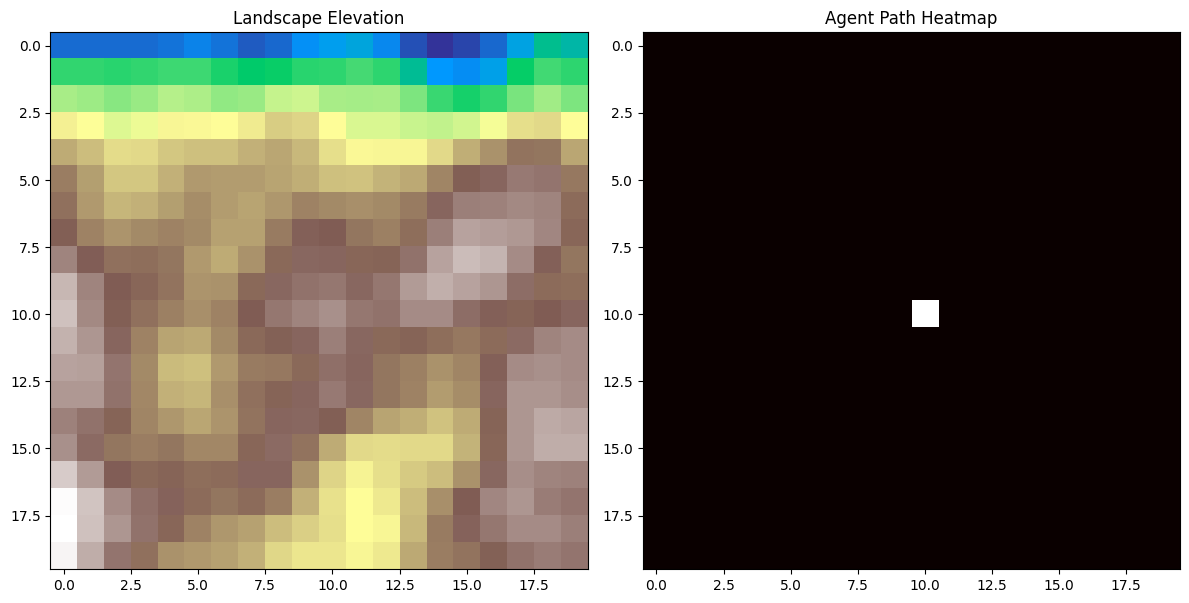

In [31]:
landscape = Landscape(20)
agent = Agent(start_position=(10, 10))
simulate(landscape, agent, 100)